* Ouzo_Sampling_Wtf_Lattice_Volume contains all the functions responsible for calculating sample information, which includes component weight fractions and stock volumes. 
* OT2_Ouzo_Commands_API2 contains the commands for the OT2 robot. 
* Ouzo_Graph_Tools contains graphing tools to help visualize and explore parameter spaces.

In [12]:
import Ouzo_Sampling_Wtf_Lattice_Volume as create
import OT2_Ouzo_Commands_API2c as ot2_commands
import Ouzo_Graph_Tools as ouzo_graphs
from opentrons import simulate, execute, protocol_api
import os
import pandas as pd
import glob, json

In [13]:
# import importlib
# importlib.reload(create)

#### Creating Samples
* Sample creation begins with the use of an csv file which contains all the information regarding sample, stock and OT2 specfication. 
    * At the moment, the excel sheet is not very flexible so do not try to stray away with changing the formatting of variables (i.e. variables shown as list should be maintained as list even if there is only one entry - See the provided templete to get started)
* The csv file can and should be opened in Excel, once opened you should note the three colors: 
    * Green: Absolute requirements in order to create samples and execute commands on the OT2.
    * Yellow: An optional transfer conducted at the end of the OT2 commands originating from the green variables. 
    * Blue: An optional and independent transer which required its own protocol object, will fail if attempting to run using protocol object tied to green and yellow.


## Step 1: Provide the path 


In [14]:
# path to work from back
dir_path_back = os.getcwd()
testing_plans_dir = dir_path_back + '\Testing Plans'
testing_plan_name = '\\Ouzo_CSV_Templete.csv' # numbers mean \\1 = \1
final_testing_plan_path = testing_plans_dir+testing_plan_name
print(final_testing_plan_path, os.path.isfile(final_testing_plan_path))
path = r"C:\Users\Edwin\Desktop\12_2_2020\12_2_2020_Lipid_Scan.csv"

C:\Users\Edwin\Desktop\OT2Protocols\ot2protocol\Ouzo_OT2_Sampling\Testing Plans\Ouzo_CSV_Templete.csv True


## Step 2: Parameter Space Explortion: 
* Searching through different stocks is useful in order to find suitable stock canidates. By iterating through a linspace of stocks alongside sample canidates graphs are produced with important information that will help you decided on a suitable stock. 
* The information regarding the iteration through stocks is found in the csv file under the variable:  Stock Concentration [min, max, n]. Another similar vairable listed as just Stock Concentration is used for single exploration.
* To select a stock provide the index number (found on graph).

### Optional: Graphing/Visualization: Will not run on OT2 jupyter notebook
* This step is useful to see the parameter space you are exploring and whether you need to expand/contract it. 
    * On the left hand side of the provided graph should be information regarding stock and sample information. 
    * It is important to load in the csv information seperately from the the final sample creation step as that step (Step 4) uses requires a stock to actual create viable samples or else will error out, which would be pointless at this stage since we are searching for stock.
    
### Looking for way to search through more than two components at a time and how to visualize this
* This would allow for multiple components to be searched for at once and then start to isolate it to a point where only 2 components are changing.
   

In [15]:
path = r"C:\Users\Edwin\Desktop\OT2Protocols\ot2protocol\Ouzo_OT2_Sampling\Testing Plans\Breaking_protocol.csv"
experiment_csv_dict = create.get_experiment_plan(path)
# all pulled string must be in string format of quotations 
wtf_sample_canidates = create.generate_candidate_lattice_concentrations(experiment_csv_dict, filter_one=True)

    dppc-stock  dspe-peg-stock  ethanol-PFH-Stock  ethanol-stock  water-stock
0          0.0          0.0875           0.000000       0.000000     0.699912
1          0.0          0.0875           0.000000       0.098453     0.622135
2          0.0          0.0875           0.000000       0.196906     0.544357
3          0.0          0.0875           0.000000       0.295359     0.466579
4          0.0          0.0875           0.000000       0.393812     0.388801
5          0.0          0.0875           0.000000       0.492264     0.311024
6          0.0          0.0875           0.000000       0.590717     0.233246
7          0.0          0.0875           0.000000       0.689170     0.155468
8          0.0          0.0875           0.000000       0.787623     0.077690
9          0.0          0.0875          23.628692       0.000000     0.606579
10         0.0          0.0875          23.628692       0.098453     0.528801
11         0.0          0.0875          23.628692       0.196906

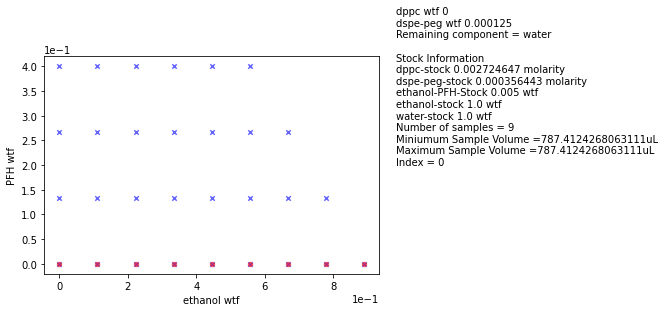

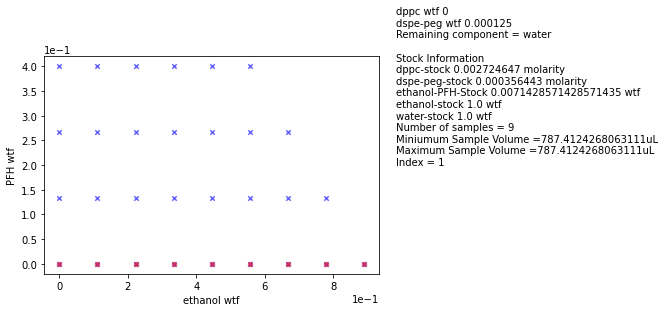

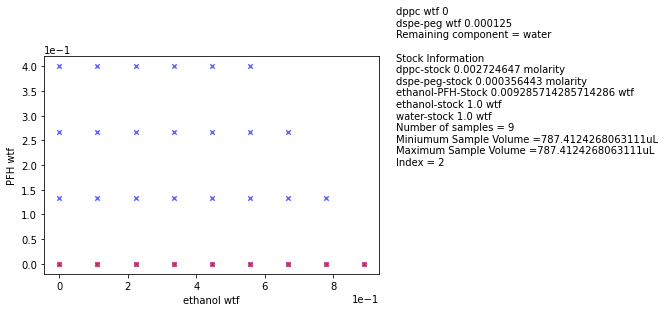

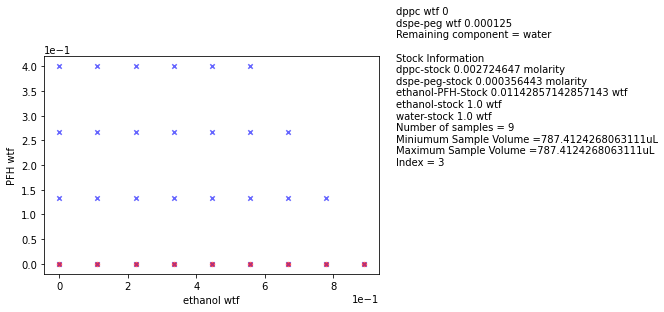

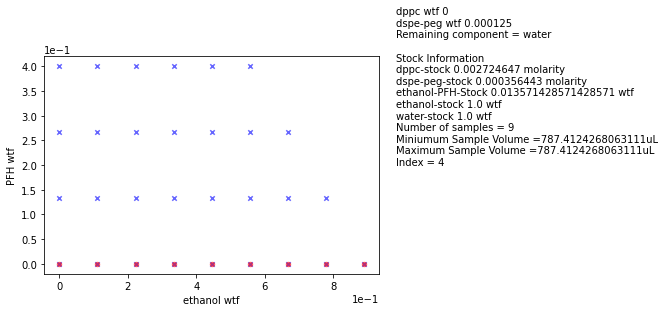

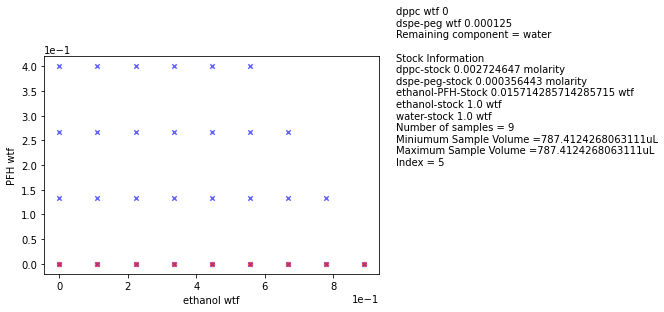

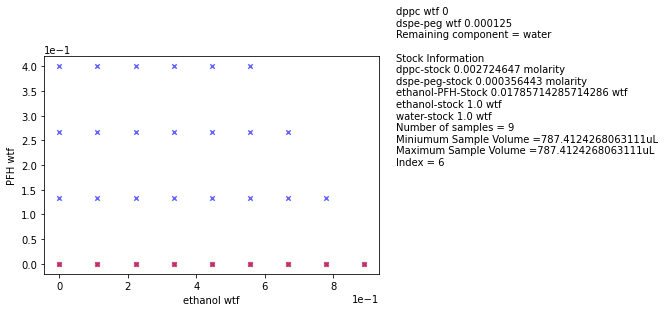

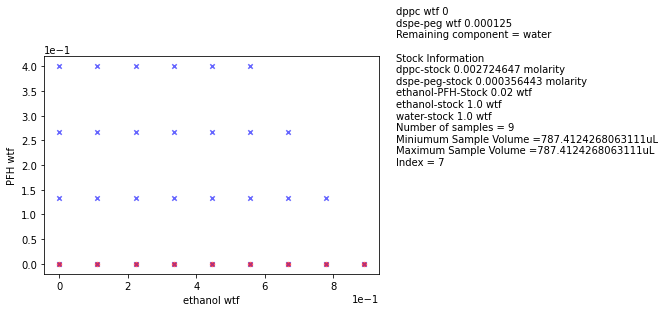

In [16]:
path = r"C:\Users\Edwin\Desktop\OT2Protocols\ot2protocol\Ouzo_OT2_Sampling\Testing Plans\Breaking_protocol.csv"
experiment_csv_dict = create.get_experiment_plan(path)
wtf_sample_canidates = create.generate_candidate_lattice_concentrations(experiment_csv_dict, filter_one=True)


# stock search is only necessary when components in the stocks are important but in certain cases you are not changing the stocks only changing the amount of stock, but fair still useful

min_pipetting_volume = 20
max_pipetting_volume = 1000

stock_unfiltered_sample_wtfs_canidates = create.generate_candidate_lattice_stocks(experiment_csv_dict)
stock_search_dict = create.prepare_stock_search(stock_unfiltered_sample_wtfs_canidates, experiment_csv_dict, wtf_sample_canidates, min_pipetting_volume, max_pipetting_volume)

ouzo_graphs.stock_search_sep(stock_search_dict,experiment_csv_dict, wtf_sample_canidates)
# making samples with zero will cause error cause not within bound
# cange into subplots to prevent this, can do interactive to so text information only when hovering


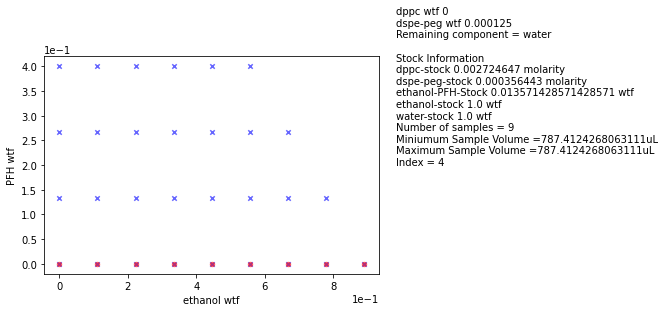

In [17]:
index = 4
selected_stock_canidate_component_wtfs = stock_search_dict['stocks_wtf_lists'][index]
selected_stock_canidate_component_volumes = stock_search_dict['stocks_volumes_lists'][index]
selected_stock_text = stock_search_dict['stock_text_info'][index]
ouzo_graphs.graph_canidates(experiment_csv_dict, wtf_sample_canidates, selected_stock_canidate_component_wtfs, additional_text = selected_stock_text)

## Step 3: Calculate stock volumes
* Determine the amount of each stock needed

In [18]:
create.calculate_stock_volumes(experiment_csv_dict, selected_stock_canidate_component_volumes)

0.0 mL of dppc-stock w/ conc of 0.002724647 molarity
0.787499341256801 mL of dspe-peg-stock w/ conc of 0.000356443 molarity
0.0 mL of ethanol-PFH-Stock w/ conc of 0.0149199 wtf
3.5443037974683533 mL of ethanol-stock w/ conc of 1 wtf
3.4992124999999996 mL of water-stock w/ conc of 1 wtf


## Step 4: Input selected stock information and volume constraints to create the experiments info dictionary. - needs to be edited - changing code flow
* This instructional dictionary will contain the following: 
    * experiment_plan_dict: A dictionary that contains all the information from the csv plan. 
    * wtf_sample_canidates: An array containing the unfiltered sample wtfs (in respective order of component to component list). 
    * volume_sample_canidates: An array containing the unfiltered sample stock volumes
    * filtered_wtf_samples: An array containing the filtered sample wtfs 
    * volume_sample_canidates: An array containing the filtered sample stock volumes

* Volume constraints (in uL) are for the purpose of preventing a single stock volume from being split up in between multiple transfer. This is important when making ouzo emulsions are the final step of water should be done in one step. Addtionally less trasnfers result in less variability. 
* If you encounter an error such as "max() arg is an empty sequence" or where a called variable is empty, the most likely cause is a result of not creating any suitable samples given the provided variables. Try to change the parameters in the excel sheet or the volume constaints, once you are able to create a dictionary step 2 will help you refine your search!


* Once you have selected the appropiate stock, create the stock and input the exact concentrations in the csv file under the variable: Stock Concentration (since mosty likely you will not create a stock concentration exactly matching selection). 
### The experiment_instruction automatically create the required volumes for the selected input stock! Just call them from the dictionary as the variables: 'volume_sample_canidates'
#
* Now you can create the appropiate variables from this stock that will be used in the final protocol: volumes and stock concentrations arrays!
* You can also restrict the number of samples you create if you are limited on labware.

In [19]:
# these variables although have the same names when searching for the stocks should now replace those for the actual selectede one. 
experiment_instructions = create.experiment_sample_dict(path, min_input_volume=20, max_input_volume=1000)
experiment_csv_dict = experiment_instructions['experiment_plan_dict']
wtf_sample_canidates = experiment_instructions['wtf_sample_canidates']
selected_filtered_wtfs = experiment_instructions['filtered_wtf_samples']
selected_filtered_volumes = experiment_instructions['filtered_volume_samples']



# lower_index = 0
# upper_index = 95
# selected_filtered_wtfs = selected_filtered_wtfs[lower_index:upper_index]
# selected_filtered_volumes = selected_filtered_volumes[lower_index:upper_index]
print('number of samples = ' + str(len(selected_filtered_wtfs)))
selected_filtered_volumes

    dppc-stock  dspe-peg-stock  ethanol-PFH-Stock  ethanol-stock  water-stock
0          0.0          0.0875           0.000000       0.000000     0.699912
1          0.0          0.0875           0.000000       0.098453     0.622135
2          0.0          0.0875           0.000000       0.196906     0.544357
3          0.0          0.0875           0.000000       0.295359     0.466579
4          0.0          0.0875           0.000000       0.393812     0.388801
5          0.0          0.0875           0.000000       0.492264     0.311024
6          0.0          0.0875           0.000000       0.590717     0.233246
7          0.0          0.0875           0.000000       0.689170     0.155468
8          0.0          0.0875           0.000000       0.787623     0.077690
9          0.0          0.0875           7.918516       0.000000     0.606579
10         0.0          0.0875           7.918516       0.098453     0.528801
11         0.0          0.0875           7.918516       0.196906

[array([  0.        ,  87.49992681,   0.        ,   0.        ,
        699.9125    ]),
 array([  0.        ,  87.49992681,   0.        ,  98.45288326,
        622.13472222]),
 array([  0.        ,  87.49992681,   0.        , 196.90576653,
        544.35694444]),
 array([  0.        ,  87.49992681,   0.        , 295.35864979,
        466.57916667]),
 array([  0.        ,  87.49992681,   0.        , 393.81153305,
        388.80138889]),
 array([  0.        ,  87.49992681,   0.        , 492.26441632,
        311.02361111]),
 array([  0.        ,  87.49992681,   0.        , 590.71729958,
        233.24583333]),
 array([  0.        ,  87.49992681,   0.        , 689.17018284,
        155.46805556]),
 array([  0.        ,  87.49992681,   0.        , 787.6230661 ,
         77.69027778])]

## Step 4a: Add optional blank
* Using the add_blank function, provide the volume for the blank, in addition to the selected wtfs and volumes for the experiment so they can be appended to the end of the respective array. Blank component information should be added to experiment csv file

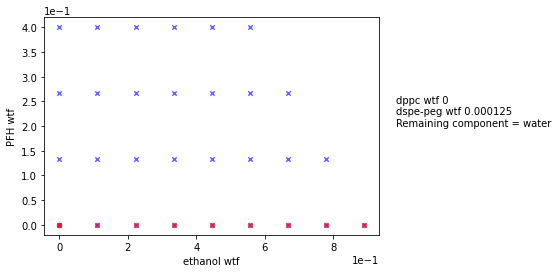

In [20]:
seleted_wtfs_plus_blank, selected_volumes_plus_blank = create.add_blank_sample(selected_filtered_wtfs, selected_filtered_volumes, 800, experiment_csv_dict['Blank Component Concentrations (wtfs)'])
ouzo_graphs.graph_canidates(experiment_csv_dict, wtf_sample_canidates, seleted_wtfs_plus_blank)
# add more useful info in graph

## Step 5: Run the OT2 commands
* Now that a stock and its corresponding volhave been selected run the command code.
* Future: make it so the can edit stock information and print the amount of stock needed (instructions for stock creation)

In [22]:
labware_dir_path = r"C:\Users\Edwin\Desktop\OT2Protocols\ot2protocol\Ouzo_OT2_Sampling\Custom Labware"
labware_dict = ot2_commands.custom_labware_dict(labware_dir_path)
selected_volumes_plus_blank

array([[  0.        ,  87.49992681,   0.        ,   0.        ,
        699.9125    ],
       [  0.        ,  87.49992681,   0.        ,  98.45288326,
        622.13472222],
       [  0.        ,  87.49992681,   0.        , 196.90576653,
        544.35694444],
       [  0.        ,  87.49992681,   0.        , 295.35864979,
        466.57916667],
       [  0.        ,  87.49992681,   0.        , 393.81153305,
        388.80138889],
       [  0.        ,  87.49992681,   0.        , 492.26441632,
        311.02361111],
       [  0.        ,  87.49992681,   0.        , 590.71729958,
        233.24583333],
       [  0.        ,  87.49992681,   0.        , 689.17018284,
        155.46805556],
       [  0.        ,  87.49992681,   0.        , 787.6230661 ,
         77.69027778],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        800.        ]])

In [ ]:
protocol = simulate.get_protocol_api('2.0')
# in order to change the dispense and aspiration speed - to match the gen1 (), use command: pipette.flow_rate.aspirate/dispense
command_info = ot2_commands.create_samples(protocol, experiment_csv_dict, selected_volumes_plus_blank, custom_labware_dict=labware_dict) 
# when not enough samples present also make sure to raise errors for things like not inputting enough slots/ len of labware does not equal len of slots 

In [ ]:
protocol1 = simulate.get_protocol_api('2.0')
ot2_commands.simple_independent_transfer(protocol1, dict_1['experiment_plan_dict'])

## Step 6: Create a csv file containing all the information of the experiment for storage and future linking

In [ ]:
create.create_csv(r"C:\Users\Edwin\Desktop\test", command_info['command info'], seleted_wtfs_plus_blank, experiment_csv_dict)
df = pd.read_csv(r"C:\Users\Edwin\Desktop\test")
# make it upload to team drive on google and have it so you can pull from there as well. 

In [ ]:
df